In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 MB 17.4 MB/s eta 0:00:00


In [ ]:
## import packages
from catboost import CatBoostClassifier, Pool
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import polars as pl
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import warnings
warnings.simplefilter('ignore')

In [ ]:
## load data
train = pl.read_csv(r'/content/drive/MyDrive/Colab Notebooks/kaggle/insurance_selling/datasets/train.csv')
test = pl.read_csv(r'/content/drive/MyDrive/Colab Notebooks/kaggle/insurance_selling/datasets/test.csv')
test = test.with_columns(pl.lit(0).cast(pl.Int64).alias('Response'))

9 9
['0-10000', '10000-20000', '50000-60000', '100000-110000', '200000-210000', '300000-310000', '400000-410000', '500000-510000', '600000-610000']


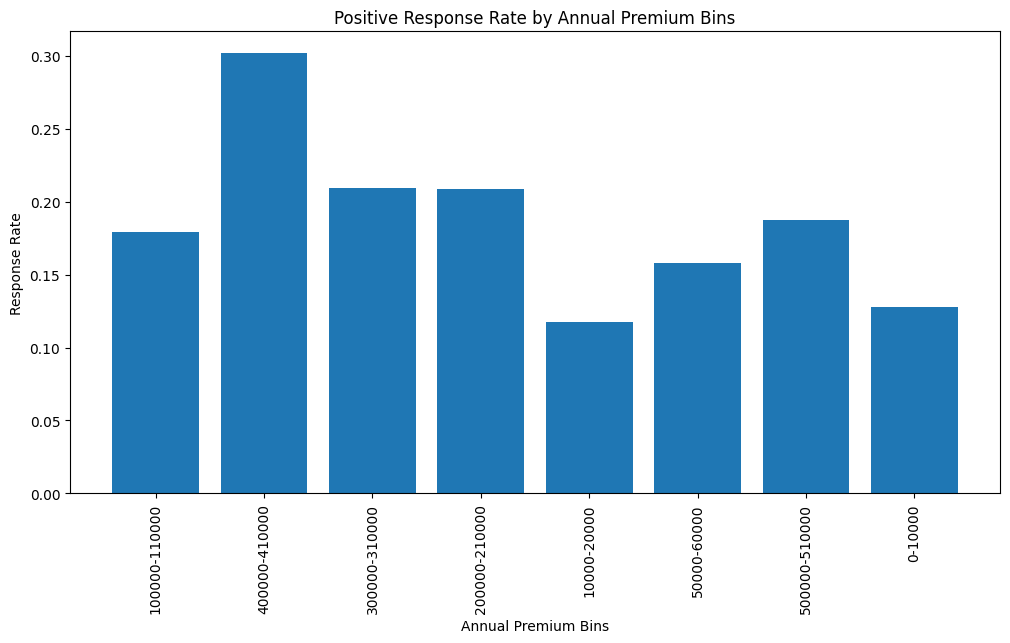

In [ ]:
# Annual Premium 구간 설정
premium_bins = [0, 10000, 50000, 100000, 200000, 300000, 400000, 500000, 600000]
premium_labels = [f'{premium_bin}-{premium_bin+10000}' for premium_bin in premium_bins]

# Annual Premium 구간화 및 새로운 열 추가
train = train.with_columns([
    train['Annual_Premium'].cut(breaks=premium_bins[1:], labels=premium_labels).alias('Premium_Binned')
])

# 구간별로 Response 값의 평균 계산
response_rate = train.groupby('Premium_Binned').agg([
    pl.mean('Response').alias('Response_Rate')
])

# 데이터프레임을 pandas로 변환 (시각화를 위해)
response_rate_df = response_rate.to_pandas()

# 시각화
plt.figure(figsize=(12, 6))
plt.bar(response_rate_df['Premium_Binned'], response_rate_df['Response_Rate'])
plt.title('Positive Response Rate by Annual Premium Bins')
plt.xlabel('Annual Premium Bins')
plt.ylabel('Response Rate')
plt.xticks(rotation=90)
plt.show()

In [ ]:
# 데이터 준비
train_data = train.clone()
test_data = test.clone()

# train_data와 test_data 합치기
df = pl.concat([train_data, test_data])

df = df.with_columns([
    pl.col('Gender').replace({'Male': 0, 'Female': 1}).cast(pl.Int32),
    pl.col('Region_Code').cast(int),
    pl.col('Vehicle_Age').replace({'< 1 Year': 0, '1-2 Year': 1, '> 2 Years': 2}).cast(pl.Int32),
    pl.col('Vehicle_Damage').replace({'No': 0, 'Yes': 1}).cast(pl.Int32),
    pl.col('Annual_Premium').cast(int),
    pl.col('Policy_Sales_Channel').cast(int)
])

df = df.with_columns([
    (pl.Series(pd.factorize((df['Previously_Insured'].cast(str) + df['Annual_Premium'].cast(str)).to_numpy())[0])).alias('Previously_Insured_Annual_Premium'),
    (pl.Series(pd.factorize((df['Previously_Insured'].cast(str) + df['Vehicle_Age'].cast(str)).to_numpy())[0])).alias('Previously_Insured_Vehicle_Age'),
    (pl.Series(pd.factorize((df['Previously_Insured'].cast(str) + df['Vehicle_Damage'].cast(str)).to_numpy())[0])).alias('Previously_Insured_Vehicle_Damage'),
    (pl.Series(pd.factorize((df['Previously_Insured'].cast(str) + df['Vintage'].cast(str)).to_numpy())[0])).alias('Previously_Insured_Vintage')
])

# # 나이 구간 설정
# age_bins = [20, 30, 40, 50, 60, 70, 80, 90]
# age_labels = [f'{age}-{age+10}' for age in age_bins]
# df = df.with_columns([
#     df['Age'].cut(breaks=age_bins[1:], labels=age_labels).alias('Age_Binned')
# ]).drop('Age')

# Annual Premium 구간 설정
premium_bins = [0, 10000, 50000, 100000, 200000, 300000, 400000, 500000, 600000]
premium_labels = [f'{premium_bin}-{premium_bin+10000}' for premium_bin in premium_bins]
df = df.with_columns([
    df['Annual_Premium'].cut(breaks=premium_bins[1:], labels=premium_labels).alias('Annual_Premium_Binned')
])

train_df = df[:train_data.shape[0]].to_pandas()
test_df = df[train_data.shape[0]:].to_pandas()

cat_features = ['Gender', 'Region_Code', 'Vehicle_Age', 'Vehicle_Damage', 'Previously_Insured', 'Policy_Sales_Channel',
                'Previously_Insured_Annual_Premium', 'Previously_Insured_Vehicle_Age', 'Previously_Insured_Vehicle_Damage', 'Previously_Insured_Vintage',
                'Annual_Premium_Binned']

train_df

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response,Previously_Insured_Annual_Premium,Previously_Insured_Vehicle_Age,Previously_Insured_Vehicle_Damage,Previously_Insured_Vintage,Annual_Premium_Binned
0,0,0,21,1,35,0,1,1,65101,124,187,0,0,0,0,0,50000-60000
1,1,0,43,1,28,0,2,1,58911,26,288,1,1,1,0,1,50000-60000
2,2,1,25,1,14,1,0,0,38043,152,254,0,2,2,1,2,10000-20000
3,3,1,35,1,1,0,1,1,2630,156,76,0,3,0,0,3,0-10000
4,4,1,36,1,15,1,1,0,31951,152,294,0,4,3,1,4,10000-20000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11504793,11504793,0,48,1,6,0,1,1,27412,26,218,0,5210,0,0,144,10000-20000
11504794,11504794,1,26,1,36,0,0,1,29509,152,115,1,23274,4,0,176,10000-20000
11504795,11504795,1,29,1,32,1,0,0,2630,152,189,0,18,2,1,456,0-10000
11504796,11504796,1,51,1,28,0,1,1,48443,26,274,1,14121,0,0,124,10000-20000


In [ ]:
## train model
aucs = []
preds = []

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for fold, (train_idx, valid_idx) in enumerate(skf.split(train_df, train_df['Response'])):
    print(f'### Fold {fold+1} Training ###')

    X_train = train_df.loc[train_idx, [c for c in train_df.columns if c not in ['id', 'Response']]]
    y_train = train_df.loc[train_idx, 'Response']
    X_valid = train_df.loc[valid_idx, X_train.columns]
    y_valid = train_df.loc[valid_idx, 'Response']
    X_test = test_df[X_train.columns]

    X_train_pool = Pool(X_train, y_train, cat_features=cat_features)
    X_valid_pool = Pool(X_valid, y_valid, cat_features=cat_features)
    X_test_pool = Pool(X_test, cat_features=cat_features)

    model = CatBoostClassifier(
        loss_function='Logloss',
        eval_metric='AUC',
        learning_rate=0.05,
        iterations=4000,
        depth=9,
        random_strength=0,
        l2_leaf_reg=0.5,
        task_type='GPU',
        random_seed=42,
        verbose=False
    )

    model.fit(X=X_train_pool, eval_set=X_valid_pool, verbose=1000, early_stopping_rounds=200)

    pred_valid = model.predict_proba(X_valid_pool)[:, 1]
    preds.append(model.predict_proba(X_test_pool)[:, 1])

    auc = roc_auc_score(y_valid, pred_valid)
    aucs.append(auc)

    print(f'Fold {fold+1} AUC: {auc:.5f}\n')

print(f'\nOverall AUC: {np.mean(aucs):.5f} +/- {np.std(aucs):.5f}')

### Fold 1 Training ###


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8765283	best: 0.8765283 (0)	total: 818ms	remaining: 54m 31s
1000:	test: 0.8941603	best: 0.8941603 (1000)	total: 15m 35s	remaining: 46m 43s
2000:	test: 0.8945040	best: 0.8945040 (2000)	total: 31m 28s	remaining: 31m 26s
3000:	test: 0.8946224	best: 0.8946224 (3000)	total: 47m 34s	remaining: 15m 50s
3999:	test: 0.8946763	best: 0.8946767 (3938)	total: 1h 3m 40s	remaining: 0us
bestTest = 0.8946766853
bestIteration = 3938
Shrink model to first 3939 iterations.
Fold 1 AUC: 0.89468

### Fold 2 Training ###


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8758847	best: 0.8758847 (0)	total: 699ms	remaining: 46m 36s
1000:	test: 0.8938456	best: 0.8938456 (1000)	total: 15m 32s	remaining: 46m 34s
2000:	test: 0.8941619	best: 0.8941619 (1995)	total: 31m 22s	remaining: 31m 20s
3000:	test: 0.8942623	best: 0.8942636 (2987)	total: 47m 27s	remaining: 15m 47s
3999:	test: 0.8943179	best: 0.8943184 (3969)	total: 1h 3m 29s	remaining: 0us
bestTest = 0.8943184018
bestIteration = 3969
Shrink model to first 3970 iterations.
Fold 2 AUC: 0.89432

### Fold 3 Training ###


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8763500	best: 0.8763500 (0)	total: 811ms	remaining: 54m 3s
1000:	test: 0.8940963	best: 0.8940963 (999)	total: 15m 32s	remaining: 46m 33s
2000:	test: 0.8943975	best: 0.8943976 (1998)	total: 31m 33s	remaining: 31m 31s
3000:	test: 0.8945121	best: 0.8945121 (3000)	total: 47m 39s	remaining: 15m 51s
3999:	test: 0.8945472	best: 0.8945482 (3961)	total: 1h 3m 41s	remaining: 0us
bestTest = 0.8945481777
bestIteration = 3961
Shrink model to first 3962 iterations.
Fold 3 AUC: 0.89455

### Fold 4 Training ###


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8763418	best: 0.8763418 (0)	total: 810ms	remaining: 54m
1000:	test: 0.8939322	best: 0.8939322 (1000)	total: 15m 24s	remaining: 46m 9s
2000:	test: 0.8942683	best: 0.8942683 (2000)	total: 31m 13s	remaining: 31m 11s
3000:	test: 0.8943886	best: 0.8943896 (2994)	total: 47m 15s	remaining: 15m 44s
3999:	test: 0.8944342	best: 0.8944368 (3909)	total: 1h 3m 19s	remaining: 0us
bestTest = 0.8944368362
bestIteration = 3909
Shrink model to first 3910 iterations.
Fold 4 AUC: 0.89444

### Fold 5 Training ###


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8768645	best: 0.8768645 (0)	total: 810ms	remaining: 53m 58s
1000:	test: 0.8945814	best: 0.8945814 (1000)	total: 15m 27s	remaining: 46m 19s
2000:	test: 0.8949016	best: 0.8949018 (1999)	total: 31m 21s	remaining: 31m 19s
3000:	test: 0.8950138	best: 0.8950144 (2995)	total: 47m 25s	remaining: 15m 47s
3999:	test: 0.8950369	best: 0.8950391 (3952)	total: 1h 3m 26s	remaining: 0us
bestTest = 0.8950390816
bestIteration = 3952
Shrink model to first 3953 iterations.
Fold 5 AUC: 0.89504


Overall AUC: 0.89460 +/- 0.00025


In [ ]:
## create submission
submission = test_df[['id']]
submission['Response'] = np.mean(preds, axis=0)

submission.to_csv('submission_240718_3.csv', index=False)
submission

,id,Response
0,11504798,0.005027
1,11504799,0.683709
2,11504800,0.238333
3,11504801,0.000164
4,11504802,0.190462
...,...,...
7669861,19174659,0.186824
7669862,19174660,0.000369
7669863,19174661,0.000447
7669864,19174662,0.625965


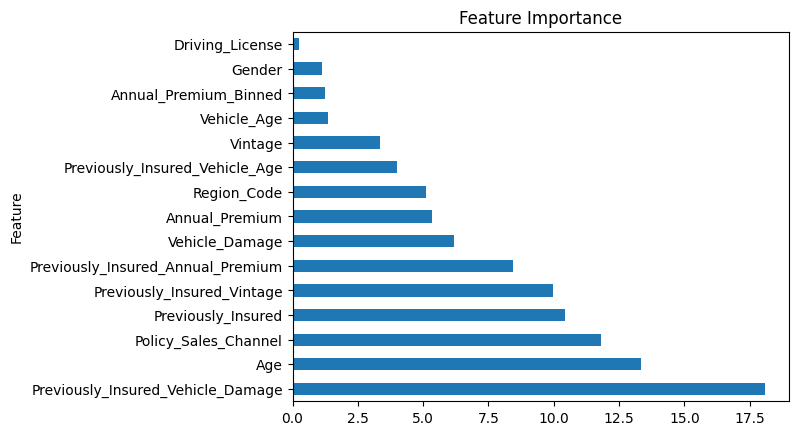

In [ ]:
# 피처 중요도 확인
feature_importances = model.get_feature_importance()
feature_names = X_train.columns

# 피처 중요도 데이터프레임 생성
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# 피처 중요도 시각화
importance_df.plot(kind='barh', x='Feature', y='Importance', legend=False)
plt.title('Feature Importance')
plt.show()